In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/MS lesion datasets refined

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MS lesion datasets refined


In [ ]:
brain_df = pd.read_csv('data_paths_refined.csv')
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3169 non-null   object
 1   image_path  3169 non-null   object
 2   mask_path   3169 non-null   object
 3   mask        3169 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 99.2+ KB


In [ ]:
brain_df

,id,image_path,mask_path,mask
0,case1,alljpgimages/case1images/0116.jpg,alljpgmasks/case1masks/0116.jpg,0
1,case1,alljpgimages/case1images/0117.jpg,alljpgmasks/case1masks/0117.jpg,0
2,case1,alljpgimages/case1images/0118.jpg,alljpgmasks/case1masks/0118.jpg,0
3,case1,alljpgimages/case1images/0119.jpg,alljpgmasks/case1masks/0119.jpg,0
4,case1,alljpgimages/case1images/0120.jpg,alljpgmasks/case1masks/0120.jpg,0
...,...,...,...,...
3164,case10,alljpgimages/case10images/0381.jpg,alljpgmasks/case10masks/0381.jpg,0
3165,case10,alljpgimages/case10images/0382.jpg,alljpgmasks/case10masks/0382.jpg,0
3166,case10,alljpgimages/case10images/0383.jpg,alljpgmasks/case10masks/0383.jpg,0
3167,case10,alljpgimages/case10images/0384.jpg,alljpgmasks/case10masks/0384.jpg,0


In [ ]:
brain_df.mask_path[2434]

'alljpgmasks/case8masks/0208.jpg'

In [ ]:
brain_df.image_path[2434]

'alljpgimages/case8images/0208.jpg'

In [ ]:
brain_df['mask'].value_counts()

0    1884
1    1285
Name: mask, dtype: int64

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [ ]:
brain_df.mask_path

0        alljpgmasks/case1masks/0116.jpg
1        alljpgmasks/case1masks/0117.jpg
2        alljpgmasks/case1masks/0118.jpg
3        alljpgmasks/case1masks/0119.jpg
4        alljpgmasks/case1masks/0120.jpg
                      ...               
3164    alljpgmasks/case10masks/0381.jpg
3165    alljpgmasks/case10masks/0382.jpg
3166    alljpgmasks/case10masks/0383.jpg
3167    alljpgmasks/case10masks/0384.jpg
3168    alljpgmasks/case10masks/0385.jpg
Name: mask_path, Length: 3169, dtype: object

In [ ]:
brain_df.image_path

0        alljpgimages/case1images/0116.jpg
1        alljpgimages/case1images/0117.jpg
2        alljpgimages/case1images/0118.jpg
3        alljpgimages/case1images/0119.jpg
4        alljpgimages/case1images/0120.jpg
                       ...                
3164    alljpgimages/case10images/0381.jpg
3165    alljpgimages/case10images/0382.jpg
3166    alljpgimages/case10images/0383.jpg
3167    alljpgimages/case10images/0384.jpg
3168    alljpgimages/case10images/0385.jpg
Name: image_path, Length: 3169, dtype: object

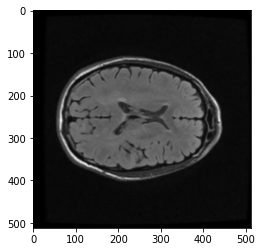

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[777]))

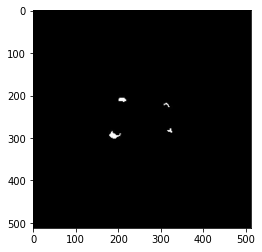

In [ ]:
plt.imshow(cv2.imread(brain_df.mask_path[777]))

In [ ]:
cv2.imread(brain_df.mask_path[777]).max()

255

In [ ]:
cv2.imread(brain_df.mask_path[777]).min()

0

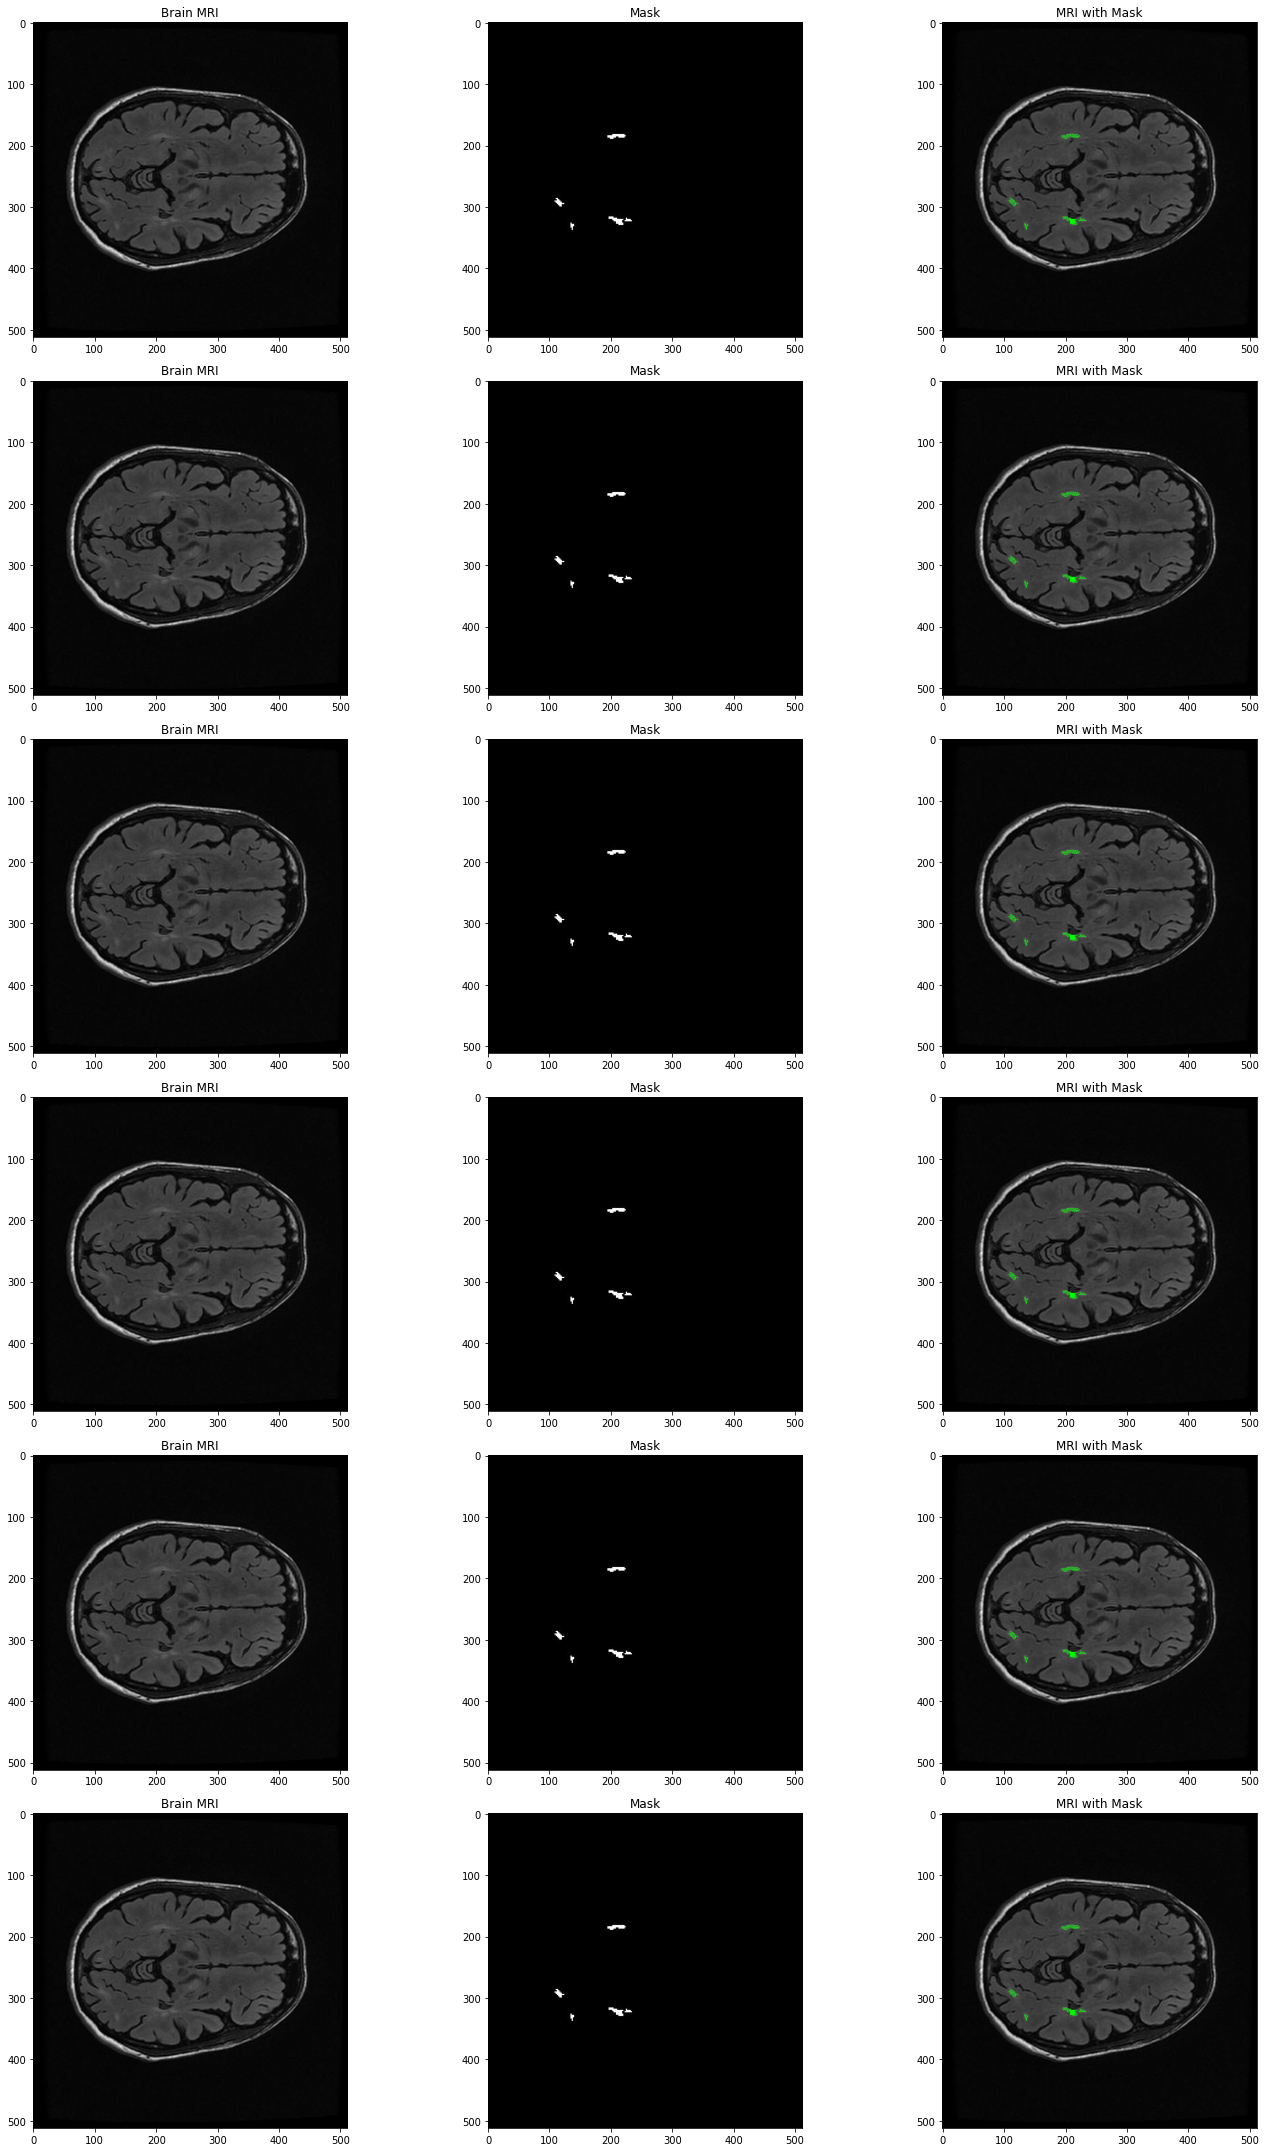

In [ ]:
count = 0 
fig, axs = plt.subplots(6,3, figsize=(20,30))

i = 2455
while count < 6:
  
  # read the images 

  img = io.imread(brain_df.image_path[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(img)

  mask = io.imread(brain_df.mask_path[i])
  axs[count][1].title.set_text("Mask")
  axs[count][1].imshow(mask, cmap = 'gray')
  
  img[mask == 255] = (0, 255, 0)    
  axs[count][2].title.set_text("MRI with Mask")
  axs[count][2].imshow(img)
  
  count += 1 

fig.tight_layout()

In [ ]:
brain_df.shape

(3169, 4)

In [ ]:
brain_df['mask'] = brain_df['mask'].apply(lambda x: str(x))

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3169 non-null   object
 1   image_path  3169 non-null   object
 2   mask_path   3169 non-null   object
 3   mask        3169 non-null   object
dtypes: object(4)
memory usage: 99.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df, test_size = 0.15)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))




Found 2290 validated image filenames belonging to 2 classes.
Found 403 validated image filenames belonging to 2 classes.
Found 476 validated image filenames belonging to 2 classes.


In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights-refined-10epochs.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=train_generator.n // 16,
                    epochs = 10,
                    validation_data= valid_generator,
                    validation_steps= valid_generator.n // 16,
                    callbacks=[checkpointer, earlystopping])

Epoch 1/10
 20/143 [===>..........................] - ETA: 9:24 - loss: 0.7001 - accuracy: 0.8125

KeyboardInterrupt: ignored

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model-for-MS-lesions-with-6epochs.json","w") as json_file:
  json_file.write(model_json)

# saving the model in h5 file
model.save('classifier-model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [ ]:
# Load pretrained model 

with open('classifier-resnet-model-for-MS-lesions-with-6epochs.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('classifier-resnet-weights-refined-6epochs.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# make prediction on userTests

# make prediction on test dataset
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

29/29 [==============================] - 3s 69ms/step


In [ ]:
test_predict.shape

(464, 2)

In [ ]:
test_predict

array([[9.91817951e-01, 8.18204228e-03],
       [1.72599152e-01, 8.27400804e-01],
       [6.08136177e-01, 3.91863823e-01],
       [9.99711096e-01, 2.88834068e-04],
       [9.95116234e-01, 4.88375546e-03],
       [1.00000000e+00, 1.23130257e-15],
       [1.50452303e-02, 9.84954834e-01],
       [9.01261359e-08, 9.99999881e-01],
       [9.99932289e-01, 6.76973868e-05],
       [7.15648353e-01, 2.84351647e-01],
       [3.41537222e-02, 9.65846300e-01],
       [9.99778807e-01, 2.21193564e-04],
       [9.99870181e-01, 1.29781969e-04],
       [3.18798320e-17, 1.00000000e+00],
       [9.99986172e-01, 1.38146397e-05],
       [1.35055336e-03, 9.98649418e-01],
       [9.99340117e-01, 6.59834361e-04],
       [8.44586875e-17, 1.00000000e+00],
       [9.99912620e-01, 8.73897588e-05],
       [9.99996781e-01, 3.16560477e-06],
       [3.02985171e-21, 1.00000000e+00],
       [5.67306779e-06, 9.99994278e-01],
       [9.96571302e-01, 3.42874834e-03],
       [1.25069011e-04, 9.99874949e-01],
       [9.999929

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0',
       '1', '0', '1', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1',
       '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1',
       '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '1', '0', '0',
       '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '1',
       '1', '0', '1', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0',
       '0', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0',
       '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0',
       '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1',
       '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '1

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

464

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9719827586206896

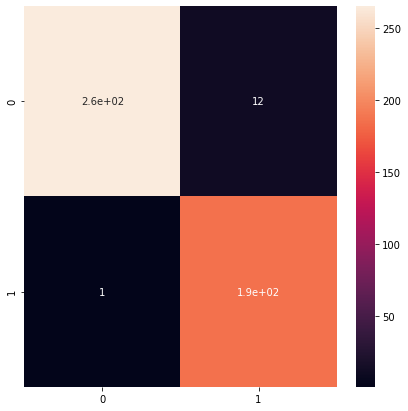

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(original, predict))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       277
           1       0.94      0.99      0.97       187

    accuracy                           0.97       464
   macro avg       0.97      0.98      0.97       464
weighted avg       0.97      0.97      0.97       464



In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
import glob
def load(np_image):
  #  np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (256, 256, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [ ]:
# user_input = load('user_data/userTest4.jpg')
# predicted_for_user_input = model.predict(user_input)
# prediction_for_user_input = []
# prediction_for_user_input.append(str(np.argmax(predicted_for_user_input)))
# prediction_for_user_input = np.asarray(prediction_for_user_input)

In [ ]:
# prediction_for_user_input

array(['1'], dtype='<U1')

In [ ]:
user_images = [cv2.imread(file) for file in glob.glob("user_data/*.jpg")]
user_images_set = []
for i in user_images:
  user_input = load(i)
  user_image_prediction = model.predict(user_input)
  user_images_set.append(str(np.argmax(user_image_prediction)))

user_images_set = np.asarray(user_images_set)

In [ ]:
user_images_set

array(['0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0',
       '0'], dtype='<U1')